<a href="https://colab.research.google.com/github/gtsagkatakis/GRSS2023_Classification_Denoising_tutorial/blob/main/Tutorial2023_Classification_UCMerced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Download the data

images: https://drive.google.com/file/d/19_QgXrE3TrgKRDo4mA1MNvXJPnp2Ohjy/view?usp=sharing

labels: https://drive.google.com/file/d/19eEHt5e7OfOvs0-Pj-4PBNAgSyWg7Oov/view?usp=sharing

Load images and labels

In [ ]:

images = np.load('/content/drive/MyDrive/@Presentations/USC_7_2023/Code/DL_tutorial_RS/DL_tutorial_RS_shared/data/UCMerced_images_orig.npy')
labels = np.load('/content/drive/MyDrive/@Presentations/USC_7_2023/Code/DL_tutorial_RS/DL_tutorial_RS_shared/data/UCMerced_labels_num.npy')

Split data in training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5, random_state=42)

total_classes = len(np.unique(labels))

Transform class label number of 1-hot-encoding

In [ ]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=total_classes)
y_test = to_categorical(y_test, num_classes=total_classes)

Define a simple CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(total_classes, activation='softmax'))  # `total_classes` should be the total number of classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
17/17 [==============================] - 9s 156ms/step - loss: 764.8394 - accuracy: 0.0562 - val_loss: 3.1910 - val_accuracy: 0.0600
Epoch 2/10
17/17 [==============================] - 2s 106ms/step - loss: 2.8438 - accuracy: 0.1267 - val_loss: 3.0308 - val_accuracy: 0.0629
Epoch 3/10
17/17 [==============================] - 2s 107ms/step - loss: 2.0824 - accuracy: 0.4257 - val_loss: 3.4128 - val_accuracy: 0.0886
Epoch 4/10
17/17 [==============================] - 2s 108ms/step - loss: 1.2670 - accuracy: 0.6619 - val_loss: 5.5887 - val_accuracy: 0.1000
Epoch 5/10
17/17 [==============================] - 2s 126ms/step - loss: 0.8281 - accuracy: 0.7810 - val_loss: 7.0784 - val_accuracy: 0.1086
Epoch 6/10
17/17 [==============================] - 2s 126ms/step - loss: 0.5716 - accuracy: 0.8610 - val_loss: 8.5596 - val_accuracy: 0.1095
Epoch 7/10
17/17 [==============================] - 2s 107ms/step - loss: 0.5245 - accuracy: 0.8962 - val_loss: 8.8325 - val_accuracy: 0.1486
Epoc

Plot loss and accuracy during training

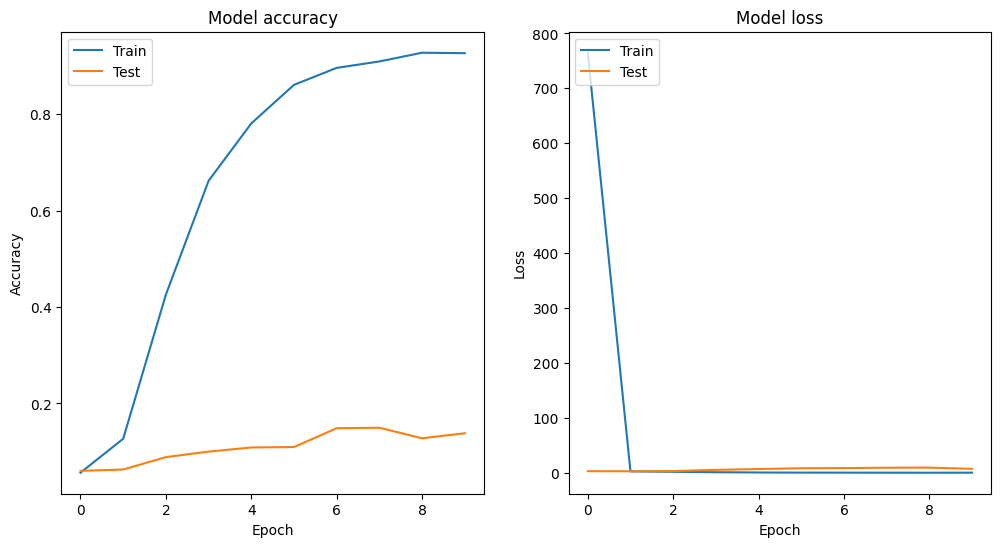

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_accuracy)
print('Test loss:', test_loss)


33/33 - 0s - loss: 7.4775 - accuracy: 0.1381 - 499ms/epoch - 15ms/step

Test accuracy: 0.13809524476528168
Test loss: 7.477494239807129


Download and load a pre-trained ResNet50

In [ ]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# load pre-trained ResNet50, exclude top FC layer
base_model = ResNet50(weights='imagenet', include_top=False)

# freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # FC layer to learn more complex features
predictions = Dense(total_classes, activation='softmax')(x)  # Final softmax layer for classification

# define new model
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Fine tune ResNet50 to UCMerced data

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
17/17 [==============================] - 14s 614ms/step - loss: 1.0316 - accuracy: 0.6848 - val_loss: 0.3127 - val_accuracy: 0.8971
Epoch 2/5
17/17 [==============================] - 7s 436ms/step - loss: 0.1491 - accuracy: 0.9467 - val_loss: 0.2384 - val_accuracy: 0.9219
Epoch 3/5
17/17 [==============================] - 9s 534ms/step - loss: 0.0289 - accuracy: 0.9924 - val_loss: 0.2099 - val_accuracy: 0.9352
Epoch 4/5
17/17 [==============================] - 9s 535ms/step - loss: 0.0149 - accuracy: 0.9990 - val_loss: 0.1960 - val_accuracy: 0.9352
Epoch 5/5
17/17 [==============================] - 9s 531ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1643 - val_accuracy: 0.9524


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_accuracy)
print('Test loss:', test_loss)

33/33 - 4s - loss: 0.1643 - accuracy: 0.9524 - 4s/epoch - 108ms/step

Test accuracy: 0.9523809552192688
Test loss: 0.16426067054271698


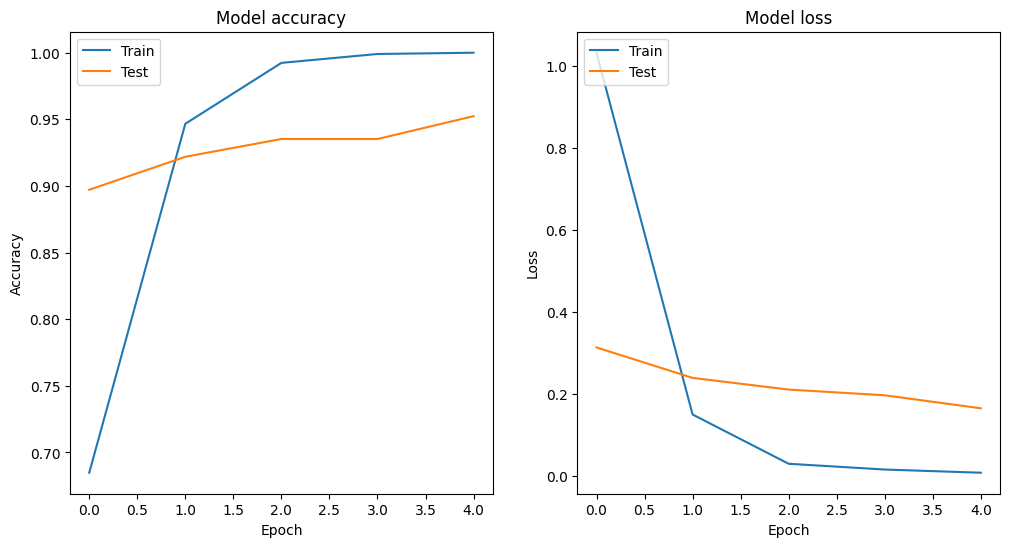

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Produce confusion matrix

33/33 [==============================] - 4s 109ms/step


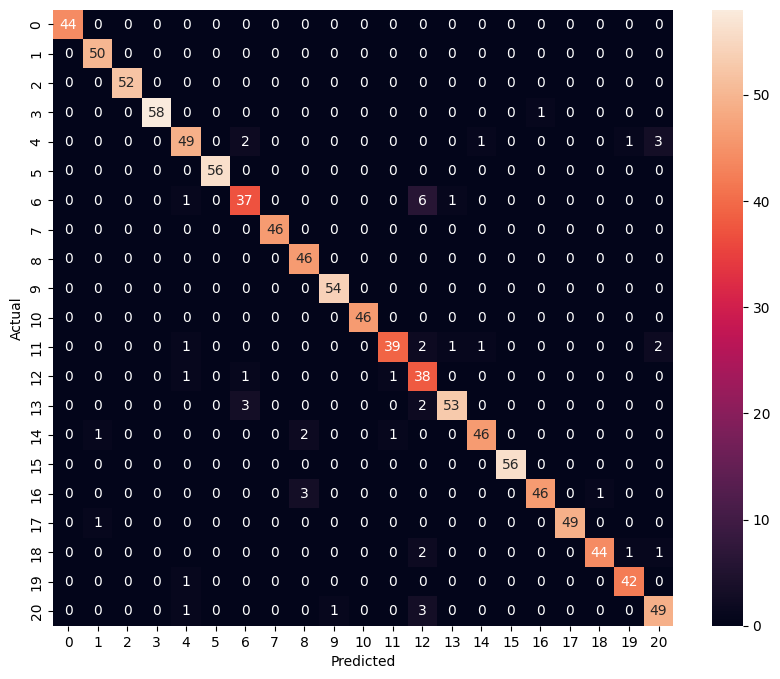

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Making prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)

# Actual labels
y_true = np.argmax(y_test,axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


33/33 [==============================] - 4s 109ms/step


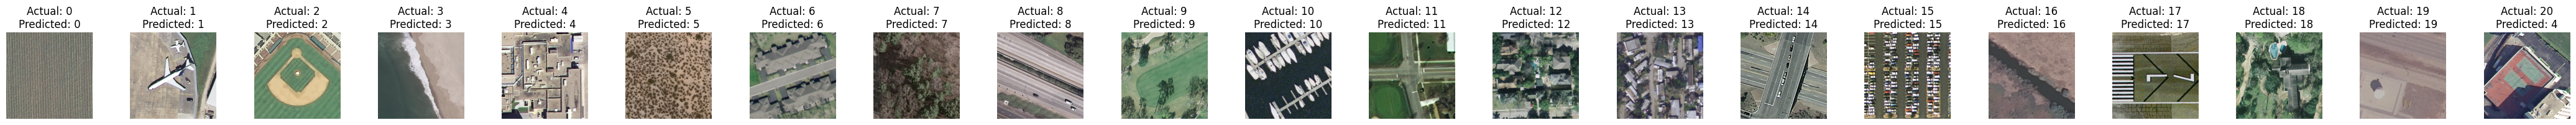

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# convert test labels and predicted labels from one-hot encoding to integers
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

unique_labels = np.unique(y_true)
num_classes = len(unique_labels)

fig, axes = plt.subplots(1, num_classes, figsize=(2*num_classes, 2))

for i, unique_label in enumerate(unique_labels):
    # find the first instance of this class in the test set
    index = np.where(y_true == unique_label)[0][0]

    axes[i].imshow(X_test[index])
    axes[i].set_title(f'Actual: {y_true[index]}\nPredicted: {y_pred[index]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
